# Create TopoJSON maps of Colombia's departments and towns from GeoJSON files

The main purpose of this work is to improve the visualization of shape maps of Colombia's deparments and towns by moving San Andrés, Providencia and Santa Catalina (archipelago hereafter) closer to mainland and increasing its size.

We start the work with departments and later replicate it for towns.

I foolishly started this endeavor by changing stuff within the TopoJSON file I created with my work in the notebook `existing_topojson_map/modify_map.ipynb`. I soon realized this was pointless (to the best of my knowledge) and started a new route. In particular, while looking for information to understand what I was doing, I learned it was possible to create a TopoJSON file from a GeoJSON file (see [John Guerra's forum on GeoJSON map of Colombia](https://gist.github.com/john-guerra/43c7656821069d00dcbc)). I looked for an official GeoJSON file of Colombia's departments and found it in the website of the Departamento Administrativo Nacional de Estadística de Colombia (DANE): [Descarga de datos geoestadísticos](https://geoportal.dane.gov.co/servicios/descarga-y-metadatos/visor-descarga-geovisores/). The file is labelled **MGN-Nivel Departamento integrado al CNPV2018** (just look for the GeoJSON column and download it).

I needed to learn how to play with the geometry to make the desired changes and then create the TopoJSON file. This notebook contains this work.

## Departments

### 1. Loading files

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import shapely

# We tell pandas we wanna see all the columns from the DataFrames
pd.set_option('display.max_columns', None)

Load and plot the TopoJSON map created in `existing_topojson_map` (left panel below) and the GeoJSON map downloaded from DANE's website (right panel below).

While working on this, I found a way to extract the TopoJSON file with Colombia's deparments from the Power BI dashboard. Recall from the work in `existing_topojson_map` this TopoJSON map has the archipelago closer to mainland and larger. However, if I want to replicate the same effect with a shape map of Colombia's towns, this file is no longer enough. I also load and plot this map to have it as a visual reference.

The idea with this work is to modify the archipelago's geometry in the GeoJSON file to create a TopoJSON map similar to the map in the middle panel below.

In [2]:
data = gpd.read_file('../existing_topojson_map/mapa_departamentos.json')
data2 = gpd.read_file('../existing_topojson_map/departamentos31686813089148425.json')
data3 = gpd.read_file('MGN_ANM_DPTOS.geojson')

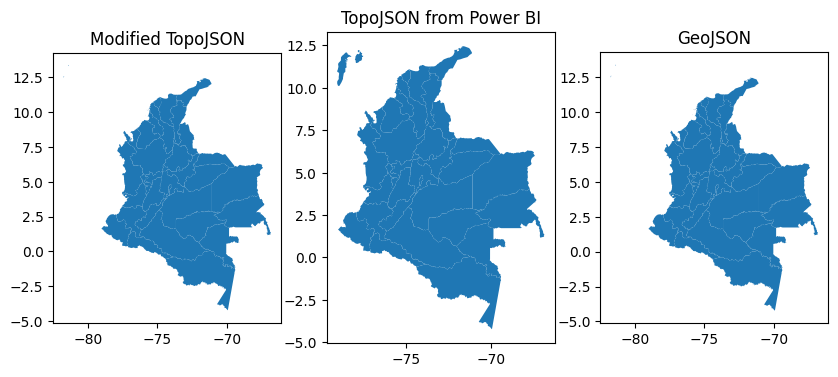

In [3]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 12))

data.plot(ax = ax[0])
ax[0].set_title('Modified TopoJSON')
data2.plot(ax = ax[1])
ax[1].set_title('TopoJSON from Power BI')
data3.plot(ax = ax[2])
ax[2].set_title('GeoJSON')

plt.show()

### 2. Exploring the GeoJSON data

In [4]:
data3.head()

,DPTO_CCDGO,DPTO_CNMBR,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,STP3_2_NO,STP3A_RI,STP3B_TCN,STP4_1_SI,STP4_2_NO,STP9_1_USO,STP9_2_USO,STP9_3_USO,STP9_4_USO,STP9_2_1_M,STP9_2_2_M,STP9_2_3_M,STP9_2_4_M,STP9_2_9_M,STP9_3_1_N,STP9_3_2_N,STP9_3_3_N,STP9_3_4_N,STP9_3_5_N,STP9_3_6_N,STP9_3_7_N,STP9_3_8_N,STP9_3_9_N,STP9_3_10,STP9_3_99,STVIVIENDA,STP14_1_TI,STP14_2_TI,STP14_3_TI,STP14_4_TI,STP14_5_TI,STP14_6_TI,STP15_1_OC,STP15_2_OC,STP15_3_OC,STP15_4_OC,TSP16_HOG,STP19_EC_1,STP19_ES_2,STP19_EE_1,STP19_EE_2,STP19_EE_3,STP19_EE_4,STP19_EE_5,STP19_EE_6,STP19_EE_9,STP19_ACU1,STP19_ACU2,STP19_ALC1,STP19_ALC2,STP19_GAS1,STP19_GAS2,STP19_GAS9,STP19_REC1,STP19_REC2,STP19_INT1,STP19_INT2,STP19_INT9,STP27_PERS,STPERSON_L,STPERSON_S,STP32_1_SE,STP32_2_SE,STP34_1_ED,STP34_2_ED,STP34_3_ED,STP34_4_ED,STP34_5_ED,STP34_6_ED,STP34_7_ED,STP34_8_ED,STP34_9_ED,STP51_PRIM,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,geometry
0,18,CAQUETÁ,2018,9.010301e+10,0.798556,-73.959468,163381.0,1117.0,162264.0,1117.0,0.0,544.0,162837.0,132937.0,5429.0,24804.0,211.0,96.0,3860.0,1117.0,243.0,113.0,160.0,5422.0,2511.0,3052.0,1250.0,10099.0,678.0,12.0,96.0,1453.0,71.0,138366.0,115307.0,18322.0,3591.0,493.0,35.0,618.0,110525.0,4306.0,7299.0,16236.0,116166.0,93242.0,17283.0,70029.0,16659.0,3868.0,523.0,20.0,7.0,2136.0,80362.0,30163.0,72630.0,37895.0,40608.0,67966.0,1951.0,80237.0,30288.0,16740.0,91374.0,2411.0,359602.0,11260.0,348342.0,182378.0,177224.0,63844.0,78433.0,62230.0,50014.0,39637.0,31396.0,19015.0,10148.0,4885.0,113225.0,24649.0,17680.0,904.0,17844.0,10238.0,21.384287,7.318485,"MULTIPOLYGON (((-74.89423 2.95852, -74.89410 2..."
1,19,CAUCA,2018,3.124291e+10,2.396834,-76.824233,622959.0,83033.0,539926.0,70827.0,12206.0,226.0,622733.0,446806.0,10837.0,165011.0,324.0,328.0,6147.0,2276.0,2016.0,70.0,810.0,10334.0,9455.0,43342.0,3515.0,86486.0,3155.0,105.0,969.0,6596.0,244.0,457643.0,372096.0,33837.0,18177.0,30035.0,2187.0,1311.0,367793.0,24327.0,32268.0,33255.0,432493.0,336910.0,30883.0,228576.0,51555.0,22577.0,10705.0,2682.0,564.0,20251.0,239233.0,128560.0,163290.0,204503.0,101100.0,264114.0,2579.0,163693.0,204100.0,57774.0,307230.0,2789.0,1243503.0,7969.0,1235534.0,615833.0,627670.0,198781.0,224899.0,218267.0,184644.0,141446.0,119102.0,81959.0,48453.0,25952.0,434283.0,195877.0,105690.0,7288.0,56673.0,17057.0,13.950263,2.534419,"MULTIPOLYGON (((-76.45922 3.32872, -76.45878 3..."
2,86,PUTUMAYO,2018,2.597628e+10,0.452260,-75.855912,147797.0,4704.0,143093.0,4659.0,45.0,1389.0,146408.0,107456.0,3397.0,36789.0,173.0,67.0,2572.0,717.0,29.0,12.0,188.0,4402.0,2485.0,6665.0,1428.0,18445.0,368.0,74.0,319.0,2334.0,81.0,110853.0,90540.0,11052.0,8098.0,684.0,49.0,430.0,91508.0,3418.0,5761.0,10166.0,107053.0,70944.0,20564.0,58033.0,9096.0,1002.0,46.0,15.0,37.0,2715.0,47315.0,44193.0,49898.0,41610.0,13261.0,77496.0,751.0,54930.0,36578.0,9947.0,80704.0,857.0,283197.0,5720.0,277477.0,142900.0,140297.0,47232.0,60789.0,51033.0,42216.0,32710.0,23515.0,14118.0,7828.0,3756.0,85979.0,30892.0,20987.0,501.0,11058.0,5630.0,12.707922,2.107965,"MULTIPOLYGON (((-76.67050 1.46732, -76.67000 1..."
3,76,VALLE DEL CAUCA,2018,2.066554e+10,3.858858,-76.518694,1674673.0,18250.0,1656423.0,3618.0,14632.0,21431.0,1653242.0,1410067.0,39096.0,224820.0,690.0,1920.0,22705.0,11986.0,2357.0,128.0,5572.0,50097.0,40191.0,32665.0,5452.0,67080.0,6881.0,169.0,1340.0,14970.0,403.0,1449163.0,902928.0,490230.0,52855.0,1173.0,518.0,1459.0,1231570.0,64873.0,41444.0,111276.0,1267039.0,1216379.0,15191.0,321720.0,438056.0,295053.0,84368.0,54589.0,16599.0,5994.0,1174360.0,57210.0,1119657.0,111913.0,1003741.0,218169.0,9660.0,1156676.0,74894.0,683961.0,537450.0,10159.0,3789874.0,27645.0,3762229.0,1800614.0,1989260.0,460691.0,571709.0,632594.0,556818.0,489478.0,468483.0,325926.0,183070.0,101105.0,851033.0,446077.0,636722.0,44248.0,111703.0,49860.0,12.650870,1.679487,"MULTIPOLYGON (((-77.23810 4.04049, -77.23774 4..."
4,94,GUAINÍA,2018,7.128935e+10,2.727843,-68.816613,13059.0,3675.0,

In [5]:
data3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 89 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DPTO_CCDGO  33 non-null     object  
 1   DPTO_CNMBR  33 non-null     object  
 2   VERSION     33 non-null     int64   
 3   AREA        33 non-null     float64 
 4   LATITUD     33 non-null     float64 
 5   LONGITUD    33 non-null     float64 
 6   STCTNENCUE  33 non-null     float64 
 7   STP3_1_SI   33 non-null     float64 
 8   STP3_2_NO   33 non-null     float64 
 9   STP3A_RI    33 non-null     float64 
 10  STP3B_TCN   33 non-null     float64 
 11  STP4_1_SI   33 non-null     float64 
 12  STP4_2_NO   33 non-null     float64 
 13  STP9_1_USO  33 non-null     float64 
 14  STP9_2_USO  33 non-null     float64 
 15  STP9_3_USO  33 non-null     float64 
 16  STP9_4_USO  33 non-null     float64 
 17  STP9_2_1_M  33 non-null     float64 
 18  STP9_2_2_M  33 non-null     float64 
 19  ST

We initially remove most of the columns 

In [6]:
data3.columns.get_indexer(data3.columns)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88])

In [7]:
column_list = [6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
               17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
               28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
               39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
               50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
               61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
               72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
               83, 84, 85]
data3.drop(data3.columns[column_list], axis = 1, inplace = True)
data3.head(2)

,DPTO_CCDGO,DPTO_CNMBR,VERSION,AREA,LATITUD,LONGITUD,Shape_Leng,Shape_Area,geometry
0,18,CAQUETÁ,2018,9.010301e+10,0.798556,-73.959468,21.384287,7.318485,"MULTIPOLYGON (((-74.89423 2.95852, -74.89410 2..."
1,19,CAUCA,2018,3.124291e+10,2.396834,-76.824233,13.950263,2.534419,"MULTIPOLYGON (((-76.45922 3.32872, -76.45878 3..."


We finish the cleaning by renaming the deparment's code column, replicating and casting it and dropping remaining unnecessary columns

In [8]:
data3.rename(columns = {'DPTO_CCDGO': 'codigo_departamento_s'}, inplace = True)
data3['codigo_departamento_n'] = data3['codigo_departamento_s'].astype(int)
columns = ['DPTO_CNMBR', 'VERSION', 'AREA', 'LATITUD', 'LONGITUD', 'Shape_Leng', 'Shape_Area']
data3.drop(columns, axis = 1, inplace = True)
data3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   codigo_departamento_s  33 non-null     object  
 1   geometry               33 non-null     geometry
 2   codigo_departamento_n  33 non-null     int64   
dtypes: geometry(1), int64(1), object(1)
memory usage: 920.0+ bytes


### 3. Archipelago geometry

#### 3.1. Moving the archipelago in the map 

An exploration of the DataFrame allowed us to see the archipelago is in the row with index 22.

We start by finding its bounds. The min bound on the $x$ coordinate will be shifted so that it overlaps with the min $x$ bound from mainland (westernmost point), while the max bound on the $y$ coordinate will bi shifted so that it overlaps with the max $y$ bound from mainland (northernmost point).

In [9]:
data3.loc[data3.index == 22, :].bounds # data3.loc[data3.index == 22, 'geometry'].bounds delivers the same

,minx,miny,maxx,maxy
22,-81.735621,12.480296,-81.349095,13.394728


In [10]:
san_andres_x = data3.loc[data3.index == 22, :].bounds['minx']
san_andres_y = data3.loc[data3.index == 22, :].bounds['maxy']

We check the bounds from the remaining departments.

In [11]:
data3[data3.index != 22].bounds

,minx,miny,maxx,maxy
0,-76.306221,-0.705840,-71.253846,2.964148
1,-77.928338,0.958028,-75.747824,3.328941
2,-77.186806,-0.562278,-73.841318,1.467315
3,-77.549773,3.091239,-75.707236,5.047394
4,-70.942492,1.165633,-66.847215,4.045026
5,-71.077931,2.737109,-67.409803,6.324317
6,-73.077769,4.287476,-69.835910,6.346111
7,-74.396344,-4.229406,-69.395496,0.097257
8,-72.033192,-1.227884,-69.115641,2.080401
9,-73.663909,0.655413,-69.995107,2.924987


We use as shifting references the northernmost and westernmost points from mainland.

In [12]:
ref_x = data3[data3.index != 22].bounds['minx'].min()
ref_y = data3[data3.index != 22].bounds['maxy'].max()

We compute the shifting amounts.

In [13]:
x_offset = (san_andres_x - ref_x)*-1
x_offset = x_offset.values[0]

y_offset = (san_andres_y - ref_y)*-1
y_offset = y_offset.values[0]

We check them.

In [14]:
x_offset, y_offset

(2.725409581000008, -0.9352844539722494)

We print the original archipelago's bounds to have them readily available for a quick comparison below.

In [15]:
data3.loc[data3.index == 22, 'geometry'].bounds

,minx,miny,maxx,maxy
22,-81.735621,12.480296,-81.349095,13.394728


We shift the archipelago's location. As we can see, the archipelago was shifted down and to the right.

In [16]:
data3.loc[data3.index == 22, 'geometry'] = data3.loc[data3.index == 22, 'geometry'].translate(xoff = x_offset, \
                                                                                              yoff = y_offset)
data3.loc[data3.index == 22, 'geometry'].bounds

,minx,miny,maxx,maxy
22,-79.010211,11.545012,-78.623685,12.459443


We visually check the result.

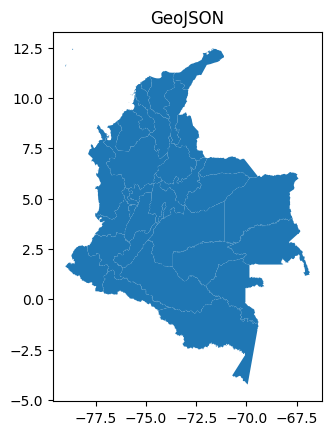

In [17]:
data3.plot()
plt.title('GeoJSON')
plt.show()

#### 3.2. Increasing the archipelago size

We increase the archipelago size by a factor of eight to explore what happens.

In [18]:
data3.loc[data3.index == 22, 'geometry'] = \
    data3.loc[data3.index == 22, 'geometry'].scale(xfact = 8, yfact = 8, origin = 'center')

We visually check the result.

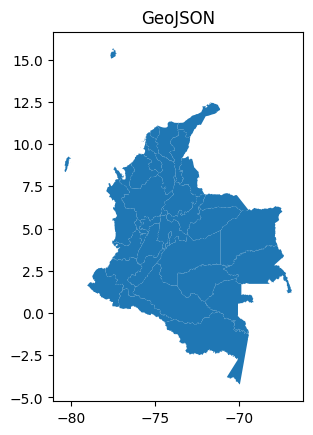

In [19]:
data3.plot()
plt.title('GeoJSON')
plt.show()

### <span style = "color:green">Comments</span>

From this exercise, we learned we need to do the following:

1. Move Providencia and Santa Catalina closer to San Andrés
2. Increase the size of the whole archipelago
3. Move the whole archipelago closer to mainland

And finally:

4. Save the modified GeoJSON and convert it to a TopoJSON format

### Step 1: Move the archipelago closer together

In [20]:
data3 = gpd.read_file('MGN_ANM_DPTOS.geojson')
column_list = [6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
               17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
               28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
               39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
               50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
               61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
               72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
               83, 84, 85]
data3.drop(data3.columns[column_list], axis = 1, inplace = True)
data3.rename(columns = {'DPTO_CCDGO': 'codigo_departamento_s'}, inplace = True)
data3['codigo_departamento_n'] = data3['codigo_departamento_s'].astype(int)
columns = ['VERSION', 'AREA', 'LATITUD', 'LONGITUD', 'Shape_Leng', 'Shape_Area']
data3.drop(columns, axis = 1, inplace = True)
data3.head(2)

,codigo_departamento_s,DPTO_CNMBR,geometry,codigo_departamento_n
0,18,CAQUETÁ,"MULTIPOLYGON (((-74.89423 2.95852, -74.89410 2...",18
1,19,CAUCA,"MULTIPOLYGON (((-76.45922 3.32872, -76.45878 3...",19


We extract the polygons that form the archipelago and plot them to get an overview.

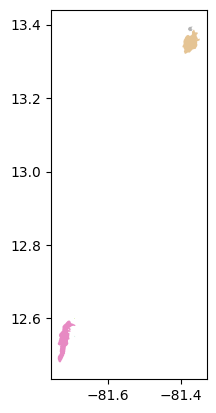

In [21]:
polys = list(shapely.ops.polygonize(data3.loc[data3.index == 22, 'geometry']))
polys = gpd.GeoSeries(polys)
polys.plot(cmap = 'Set2')
plt.show()

Out of curiosity, we check how many polygons each department has. It turns out the archipelago has six.

In [22]:
for index, row in data3.iterrows():
    polys = list(shapely.ops.polygonize(row['geometry']))
    print(row['DPTO_CNMBR'] + "'s polygons: " + str(len(polys)))

CAQUETÁ's polygons: 1
CAUCA's polygons: 1
PUTUMAYO's polygons: 1
VALLE DEL CAUCA's polygons: 2
GUAINÍA's polygons: 1
VICHADA's polygons: 1
CASANARE's polygons: 1
AMAZONAS's polygons: 1
VAUPÉS's polygons: 1
GUAVIARE's polygons: 1
CALDAS's polygons: 1
QUINDIO's polygons: 1
RISARALDA's polygons: 1
ANTIOQUIA's polygons: 1
CHOCÓ's polygons: 1
NARIÑO's polygons: 2
CÓRDOBA's polygons: 1
BOLÍVAR's polygons: 50
CESAR's polygons: 1
LA GUAJIRA's polygons: 1
MAGDALENA's polygons: 1
SUCRE's polygons: 1
ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANTA CATALINA's polygons: 6
ARAUCA's polygons: 1
BOYACÁ's polygons: 1
CUNDINAMARCA's polygons: 1
NORTE DE SANTANDER's polygons: 1
BOGOTÁ, D.C.'s polygons: 1
META's polygons: 1
HUILA's polygons: 1
SANTANDER's polygons: 1
TOLIMA's polygons: 1
ATLÁNTICO's polygons: 1


We check each polygon separately.

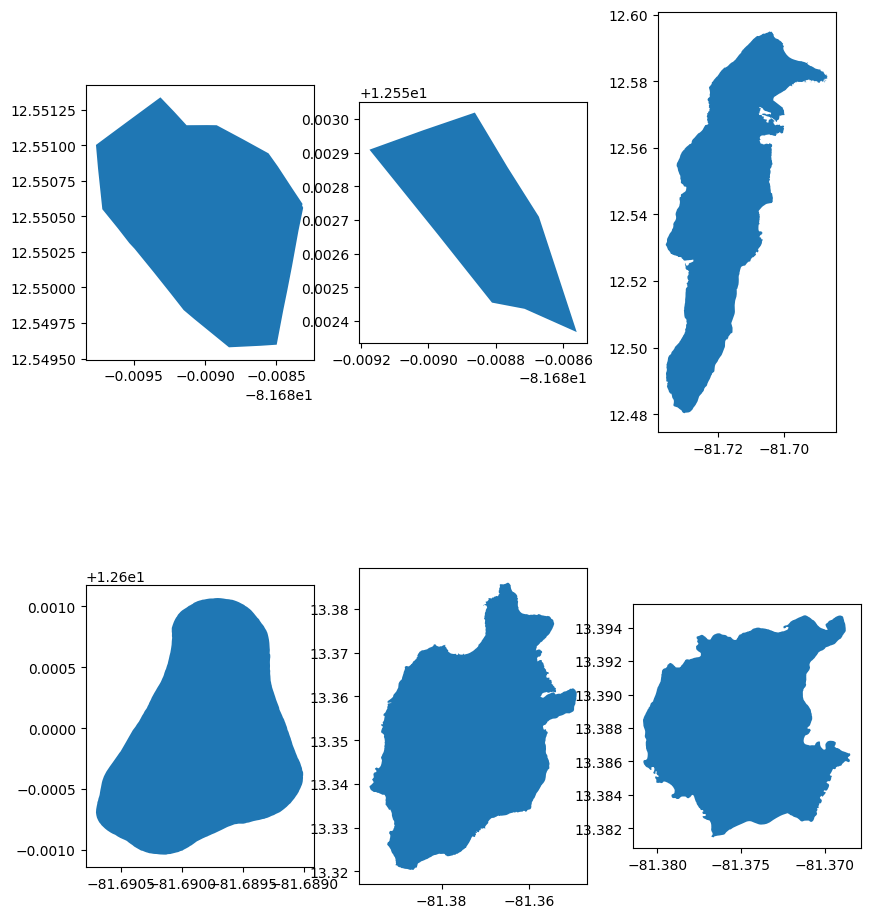

In [23]:
polys = list(shapely.ops.polygonize(data3.loc[data3.index == 22, 'geometry']))
polygon_list = []
for i in range(len(polys)):
    polygon_list.append(gpd.GeoSeries(polys[i]))

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 12))
polygon_list[0].plot(ax = ax[0, 0])
polygon_list[1].plot(ax = ax[0, 1])
polygon_list[2].plot(ax = ax[0, 2])
polygon_list[3].plot(ax = ax[1, 0])
polygon_list[4].plot(ax = ax[1, 1])
polygon_list[5].plot(ax = ax[1, 2])
plt.show()

Checking Google Maps, we see the first four polygons correspond to San Andrés and close small islands. We group these four islands into a multipolygon. The last two polygons correspond to Providencia and Santa Catalina. We group these two into another multipolygon.

In [24]:
san_andres_r = Polygon()
san_andres_r = san_andres_r.union(polygon_list[0]).union(polygon_list[1]).union(polygon_list[2]).union(polygon_list[3])
san_andres_r.bounds

,minx,miny,maxx,maxy
0,-81.735621,12.480296,-81.687061,12.601067


In [25]:
providencia_r = Polygon()
providencia_r = providencia_r.union(polygon_list[4]).union(polygon_list[5])
providencia_r.bounds

,minx,miny,maxx,maxy
0,-81.396479,13.32034,-81.349095,13.394728


We move San Andrés (and close islands) closer to Providencia and Santa Catalina (move it to the right or east and to the north). To avoid and overlap, we add some space between both multipolygons. The space is 1.5 times the size of San Andrés in the $x$ coordinate.

In [26]:
space = (polygon_list[2].bounds['minx']*-1)-(polygon_list[2].bounds['maxx']*-1)
space = space.values[0]*1.5

san_andres_x = san_andres_r.bounds['minx']
ref_x = providencia_r.bounds['minx']
x_offset = (san_andres_x - ref_x)*-1
x_offset = x_offset.values[0] - space

san_andres_y = san_andres_r.bounds['maxy']
ref_y = providencia_r.bounds['maxy']
y_offset = (ref_y - san_andres_y)
y_offset = y_offset.values[0]

san_andres_r = san_andres_r.translate(xoff = x_offset, yoff = y_offset)
san_andres_r.bounds

,minx,miny,maxx,maxy
0,-81.469319,13.273957,-81.420759,13.394728


We bring all polygons back together.

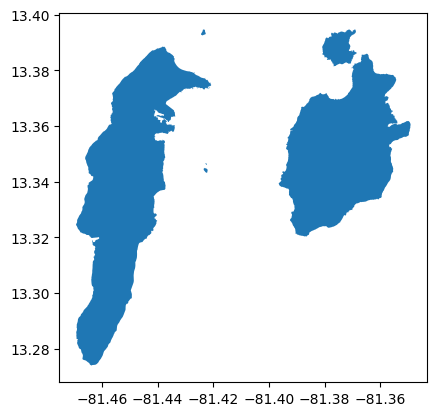

In [27]:
san_andres_polys = list(shapely.ops.polygonize(san_andres_r))
san_andres_list = []
for i in range(len(san_andres_polys)):
    san_andres_list.append(gpd.GeoSeries(san_andres_polys[i]))

providencia_polys = list(shapely.ops.polygonize(providencia_r))
providencia_list = []
for i in range(len(providencia_polys)):
    providencia_list.append(gpd.GeoSeries(providencia_polys[i]))

polygon_list[0] = san_andres_list[0]
polygon_list[1] = san_andres_list[1]
polygon_list[2] = san_andres_list[2]
polygon_list[3] = san_andres_list[3]
polygon_list[4] = providencia_list[0]
polygon_list[5] = providencia_list[1]

new_multipolygon = Polygon()
for polygon in polygon_list:
    new_multipolygon = new_multipolygon.union(polygon)

new_multipolygon.plot()
plt.show()

And update the corresponding data.

In [28]:
data3.loc[data3.index == 22, 'geometry'] = new_multipolygon.values[0]

We visually check the result.

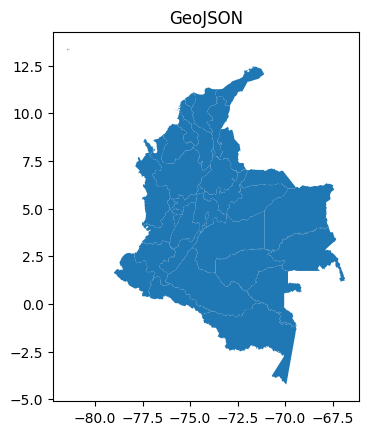

In [29]:
data3.plot()
plt.title('GeoJSON')
plt.show()

### Step 2: Increase the archipelago size

We increase the archipelago size by a factor of 18.

In [30]:
data3.loc[data3.index == 22, 'geometry'] = \
    data3.loc[data3.index == 22, 'geometry'].scale(xfact = 18, yfact = 18, origin = 'center')

We visually check the result.

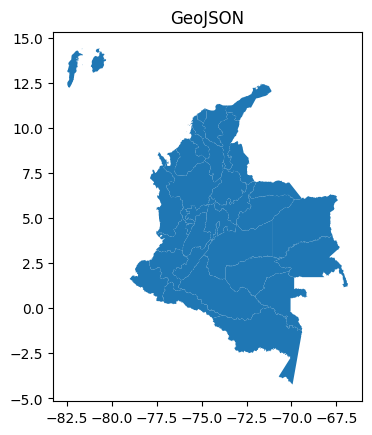

In [31]:
data3.plot()
plt.title('GeoJSON')
plt.show()

### Step 3: Move the archipelago closer to mainland

In [32]:
archipelago_x = data3.loc[data3.index == 22, 'geometry'].bounds['minx']
archipelago_y = data3.loc[data3.index == 22, 'geometry'].bounds['maxy']
ref_x = data3.loc[data3.index != 22, 'geometry'].bounds['minx'].min()
ref_y = data3.loc[data3.index != 22, 'geometry'].bounds['maxy'].max()

x_offset = (archipelago_x - ref_x)*-1
x_offset = x_offset.values[0]
y_offset = (archipelago_y - ref_y)*-1
y_offset = y_offset.values[0]

data3.loc[data3.index == 22, 'geometry'] = data3.loc[data3.index == 22, 'geometry'].translate(xoff = x_offset, \
                                                                                              yoff = y_offset)
data3.loc[data3.index == 22, 'geometry'].bounds

,minx,miny,maxx,maxy
22,-79.010211,10.285573,-76.846188,12.459443


We visually check the result.

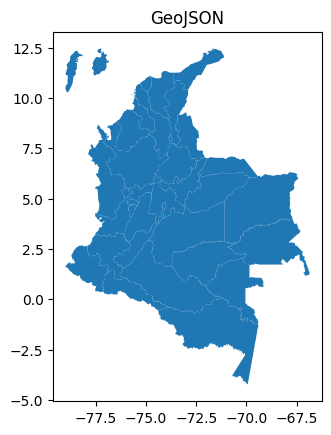

In [33]:
data3.plot()
plt.title('GeoJSON')
plt.show()

<span style = "color:red">The following cell is run to extract a given shifting reference to be used later when working with the towns map. We save it in a CSV file and load it later when needed. Look for the last **Comments** and **Final work** in the towns work to get a sense of the specific purpose of this cell.</span>

In [34]:
polys = list(shapely.ops.polygonize(data3.loc[data3.index == 22, 'geometry']))
polygon_list = []
for i in range(len(polys)):
    polygon_list.append(gpd.GeoSeries(polys[i]))

town_x_reference = polygon_list[4].bounds['minx']
town_x_reference.to_csv('town_x_reference.csv', index = False)

We check the dataframe and perform some final esthetic processing.

In [35]:
data3.head(2)

,codigo_departamento_s,DPTO_CNMBR,geometry,codigo_departamento_n
0,18,CAQUETÁ,"MULTIPOLYGON (((-74.89423 2.95852, -74.89410 2...",18
1,19,CAUCA,"MULTIPOLYGON (((-76.45922 3.32872, -76.45878 3...",19


In [36]:
series = data3['geometry']
data3.drop(['DPTO_CNMBR', 'geometry'], axis = 1, inplace = True)
data3['geometry'] = series
data3.head()

,codigo_departamento_s,codigo_departamento_n,geometry
0,18,18,"MULTIPOLYGON (((-74.89423 2.95852, -74.89410 2..."
1,19,19,"MULTIPOLYGON (((-76.45922 3.32872, -76.45878 3..."
2,86,86,"MULTIPOLYGON (((-76.67050 1.46732, -76.67000 1..."
3,76,76,"MULTIPOLYGON (((-77.23810 4.04049, -77.23774 4..."
4,94,94,"MULTIPOLYGON (((-67.67638 3.91228, -67.67305 3..."


We save the data.

In [37]:
#data3.to_file('MGN_ANM_DPTOS_rJAC.geojson', driver = 'GeoJSON', crs = 'EPSG:3116')
data3.to_file('MGN_ANM_DPTOS_rJAC.geojson', driver = 'GeoJSON')

### Step 4: Convert GeoJSON to TopoJSON

The final step is to convert the GeoJSON file to a TopoJSON format using topojson server (in **Additional sources** I mention some sources that can help you get started with topojson server): 

```bash
geo2topo -q 1e4 MGN_ANM_DPTOS_rJAC.geojson > mapa_departamentos.json
```

Below there's a screenshot of how the TopoJSON map looks like in a Power BI dashboard.

![dashboard](../images/dashboard_departments_r.png)

## Towns

The official GeoJSON file of Colombia's towns can be found in the DANE's website: [Descarga de datos geoestadísticos](https://geoportal.dane.gov.co/servicios/descarga-y-metadatos/visor-descarga-geovisores/). The file is labelled **MGN-Nivel Municipio integrado al CNPV2018** (just look for the GeoJSON column and download it).

### Replicating the departments work

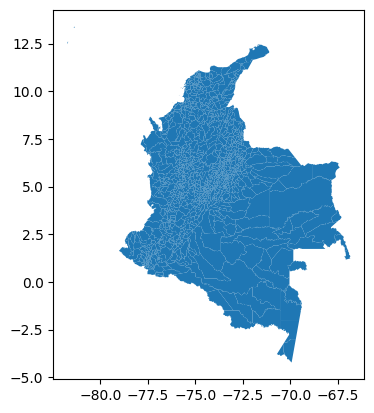

In [38]:
data4 = gpd.read_file('MGN_ANM_MPIOS.geojson')
data4.plot()
plt.show()

In [39]:
data4.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 91 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DPTO_CCDGO  1122 non-null   object  
 1   MPIO_CCDGO  1122 non-null   object  
 2   MPIO_CNMBR  1122 non-null   object  
 3   MPIO_CDPMP  1122 non-null   object  
 4   VERSION     1122 non-null   int64   
 5   AREA        1122 non-null   float64 
 6   LATITUD     1122 non-null   float64 
 7   LONGITUD    1122 non-null   float64 
 8   STCTNENCUE  1122 non-null   float64 
 9   STP3_1_SI   1122 non-null   float64 
 10  STP3_2_NO   1122 non-null   float64 
 11  STP3A_RI    1122 non-null   float64 
 12  STP3B_TCN   1122 non-null   float64 
 13  STP4_1_SI   1122 non-null   float64 
 14  STP4_2_NO   1122 non-null   float64 
 15  STP9_1_USO  1122 non-null   float64 
 16  STP9_2_USO  1122 non-null   float64 
 17  STP9_3_USO  1122 non-null   float64 
 18  STP9_4_USO  1122 non-null   float64 
 19

In [40]:
data4[data4['DPTO_CCDGO'] == '88']

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,STP3_2_NO,STP3A_RI,STP3B_TCN,STP4_1_SI,STP4_2_NO,STP9_1_USO,STP9_2_USO,STP9_3_USO,STP9_4_USO,STP9_2_1_M,STP9_2_2_M,STP9_2_3_M,STP9_2_4_M,STP9_2_9_M,STP9_3_1_N,STP9_3_2_N,STP9_3_3_N,STP9_3_4_N,STP9_3_5_N,STP9_3_6_N,STP9_3_7_N,STP9_3_8_N,STP9_3_9_N,STP9_3_10,STP9_3_99,STVIVIENDA,STP14_1_TI,STP14_2_TI,STP14_3_TI,STP14_4_TI,STP14_5_TI,STP14_6_TI,STP15_1_OC,STP15_2_OC,STP15_3_OC,STP15_4_OC,TSP16_HOG,STP19_EC_1,STP19_ES_2,STP19_EE_1,STP19_EE_2,STP19_EE_3,STP19_EE_4,STP19_EE_5,STP19_EE_6,STP19_EE_9,STP19_ACU1,STP19_ACU2,STP19_ALC1,STP19_ALC2,STP19_GAS1,STP19_GAS2,STP19_GAS9,STP19_REC1,STP19_REC2,STP19_INT1,STP19_INT2,STP19_INT9,STP27_PERS,STPERSON_L,STPERSON_S,STP32_1_SE,STP32_2_SE,STP34_1_ED,STP34_2_ED,STP34_3_ED,STP34_4_ED,STP34_5_ED,STP34_6_ED,STP34_7_ED,STP34_8_ED,STP34_9_ED,STP51_PRIM,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,geometry
628,88,001,SAN ANDRÉS,88001,2018,2.713979e+07,12.543179,-81.717572,22801.0,0.0,22801.0,0.0,0.0,5.0,22796.0,16151.0,254.0,6383.0,13.0,6.0,108.0,140.0,0.0,0.0,28.0,889.0,1077.0,3.0,99.0,3779.0,28.0,1.0,9.0,461.0,9.0,16405.0,9303.0,5338.0,1650.0,0.0,59.0,55.0,14540.0,132.0,988.0,745.0,14672.0,14468.0,72.0,4026.0,6171.0,3393.0,376.0,157.0,45.0,300.0,4470.0,10070.0,2592.0,11948.0,0.0,14540.0,0.0,14158.0,382.0,3849.0,10620.0,71.0,43754.0,465.0,43289.0,21114.0,22640.0,6156.0,6495.0,7306.0,6560.0,5629.0,6334.0,3331.0,1382.0,561.0,6251.0,3851.0,8106.0,158.0,462.0,759.0,0.386967,0.002219,"MULTIPOLYGON (((-81.68922 12.55124, -81.68913 ..."
629,88,564,PROVIDENCIA,88564,2018,2.228446e+07,13.353250,-81.373939,4162.0,0.0,4162.0,0.0,0.0,6.0,4156.0,1953.0,52.0,2157.0,0.0,0.0,10.0,42.0,0.0,0.0,2.0,96.0,199.0,1.0,58.0,1688.0,9.0,0.0,4.0,99.0,1.0,2005.0,1742.0,102.0,136.0,2.0,11.0,12.0,1657.0,1.0,103.0,244.0,1682.0,1634.0,23.0,229.0,1093.0,273.0,16.0,4.0,0.0,19.0,1470.0,187.0,95.0,1562.0,0.0,1657.0,0.0,1571.0,86.0,484.0,1168.0,5.0,4545.0,0.0,4545.0,2212.0,2333.0,643.0,719.0,719.0,666.0,596.0,605.0,369.0,150.0,78.0,452.0,208.0,994.0,7.0,42.0,36.0,0.298292,0.001831,"MULTIPOLYGON (((-81.36434 13.38561, -81.36429 ..."


In [41]:
polys = list(shapely.ops.polygonize(data4.loc[data4.index == 628, 'geometry']))
print(data4.loc[data4.index == 628, 'MPIO_CNMBR']  + "'s polygons: " + str(len(polys)))

628    SAN ANDRÉS's polygons: 4
Name: MPIO_CNMBR, dtype: object


<Axes: >

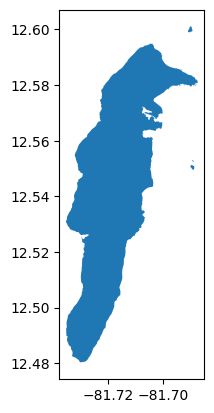

In [42]:
data4.loc[data4.index == 628, 'geometry'].plot()

In [43]:
polys = list(shapely.ops.polygonize(data4.loc[data4.index == 629, 'geometry']))
print(data4.loc[data4.index == 629, 'MPIO_CNMBR']  + "'s polygons: " + str(len(polys)))

629    PROVIDENCIA's polygons: 2
Name: MPIO_CNMBR, dtype: object


<Axes: >

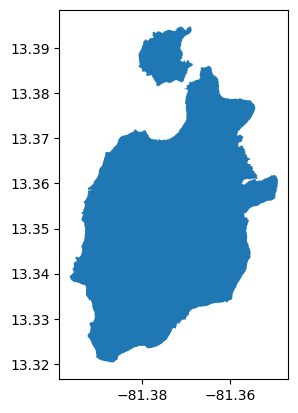

In [44]:
data4.loc[data4.index == 629, 'geometry'].plot()

We move San Andrés closer to Providencia.

In [45]:
data4.loc[data4.index == 628, 'geometry'].bounds

,minx,miny,maxx,maxy
628,-81.735621,12.480296,-81.687061,12.601067


In [46]:
space = (data4.loc[data4.index == 628, 'geometry'].bounds['minx']*-1) - \
        (data4.loc[data4.index == 628, 'geometry'].bounds['maxx']*-1)
space = space.values[0]*1.5

san_andres_x = data4.loc[data4.index == 628, 'geometry'].bounds['minx']
ref_x = data4.loc[data4.index == 629, 'geometry'].bounds['minx']
x_offset = (san_andres_x.values[0] - ref_x.values[0])*-1 - space

san_andres_y = data4.loc[data4.index == 628, 'geometry'].bounds['maxy']
ref_y = data4.loc[data4.index == 629, 'geometry'].bounds['maxy']
y_offset = (ref_y.values[0] - san_andres_y.values[0])

data4.loc[data4.index == 628, 'geometry'] = data4.loc[data4.index == 628, 'geometry'].translate(xoff = x_offset, \
                                                                                                yoff = y_offset)
data4.loc[data4.index == 628, 'geometry'].bounds

,minx,miny,maxx,maxy
628,-81.469319,13.273957,-81.420759,13.394728


We visually check the result.

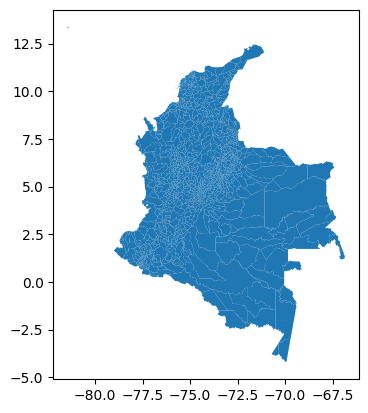

In [47]:
data4.plot()
plt.show()

We increase the archipelago size by a factor of 18.

In [48]:
data4.loc[data4.index == 628, 'geometry'] = \
    data4.loc[data4.index == 628, 'geometry'].scale(xfact = 18, yfact = 18, origin = 'center')
data4.loc[data4.index == 629, 'geometry'] = \
    data4.loc[data4.index == 629, 'geometry'].scale(xfact = 18, yfact = 18, origin = 'center')

We visually check the result.

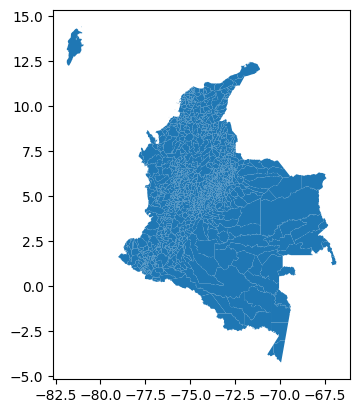

In [49]:
data4.plot()
plt.show()

### <span style = "color:green">Comments</span>

If we increase the islands size after moving them closer together, they overlap as we can see above. This is so because unlike the departments GeoJSON, where the whole archipelago is within a single multipolygon, the towns GeoJSON has the archipelago split into two multipolygons. A non-reported exercise shows the same happens if we increase the islands size first and then move them closer together.

Thus, the first solution that came to my mind was to move San Andrés and Providencia closer together, merge them in a single multipolygon (like in the departments work), increase the whole polygon size, move the whole polygon closer to mainland and split them back (to have them as separate towns). But after some thought, I think we can simply increase the size of both, shift San Andrés closer to mainland first and then shift Providencia using as shifting references coordinates from the new San Andrés' location.

### Step 1: Increase the archipelago size 

We increase the archipelago size by a factor of 18.

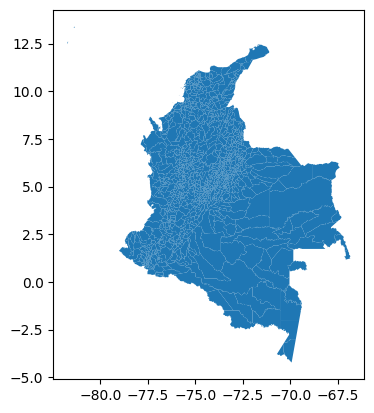

In [50]:
data4 = gpd.read_file('MGN_ANM_MPIOS.geojson')
data4.plot()
plt.show()

In [51]:
data4.loc[data4.index == 628, 'geometry'] = \
    data4.loc[data4.index == 628, 'geometry'].scale(xfact = 18, yfact = 18, origin = 'center')
data4.loc[data4.index == 629, 'geometry'] = \
    data4.loc[data4.index == 629, 'geometry'].scale(xfact = 18, yfact = 18, origin = 'center')

We visually check the result.

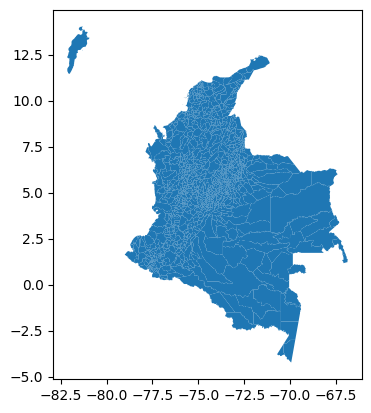

In [52]:
data4.plot()
plt.show()

### Step 2: Move San Andrés closer to mainland

We move San Andrés closer to mainland.

In [53]:
data4.loc[data4.index == 628,'geometry'].bounds

,minx,miny,maxx,maxy
628,-82.14838,11.453746,-81.274302,13.627617


In [54]:
san_andres_x = data4.loc[data4.index == 628,'geometry'].bounds['minx']
san_andres_y = data4.loc[data4.index == 628,'geometry'].bounds['maxy']
san_andres_x, san_andres_y

(628   -82.14838
 Name: minx, dtype: float64,
 628    13.627617
 Name: maxy, dtype: float64)

We use as shifting references the northernmost and westernmost points from mainland.

In [55]:
ref_x = data4[(data4.index != 628) & (data4.index != 629)].bounds['minx'].min()
ref_y = data4[(data4.index != 628) & (data4.index != 629)].bounds['maxy'].max()
ref_x, ref_y

(-79.0102109749999, 12.459443307602095)

We compute the shifting amounts.

In [56]:
x_offset = (san_andres_x - ref_x)*-1
x_offset = x_offset.values[0]
y_offset = (san_andres_y - ref_y)*-1
y_offset = y_offset.values[0]
x_offset, y_offset

(3.1381686715002957, -1.1681736639655522)

We print the original bounds to have them readily available for a quick comparison below.

In [57]:
data4.loc[data4.index == 628,'geometry'].bounds

,minx,miny,maxx,maxy
628,-82.14838,11.453746,-81.274302,13.627617


We shift San Andrés' location. As we can see, San Andrés was shifted down and to the right.

In [58]:
data4.loc[data4.index == 628, 'geometry'] = data4.loc[data4.index == 628, 'geometry'].translate(xoff = x_offset, \
                                                                                                yoff = y_offset)
data4.loc[data4.index == 628, 'geometry'].bounds

,minx,miny,maxx,maxy
628,-79.010211,10.285573,-78.136133,12.459443


We visually check the result.

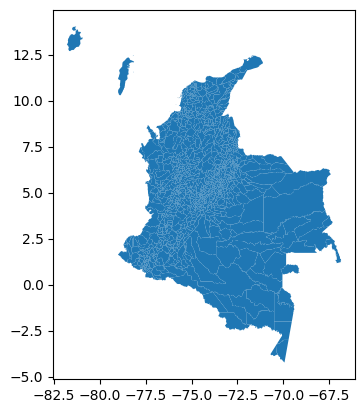

In [59]:
data4.plot()
plt.show()

### Step 3: Move Providencia

In [60]:
data4.loc[data4.index == 629, 'geometry'].bounds

,minx,miny,maxx,maxy
629,-81.79924,12.68804,-80.946334,14.027027


In [61]:
providencia_x = data4.loc[data4.index == 629, 'geometry'].bounds['minx']
providencia_y = data4.loc[data4.index == 629, 'geometry'].bounds['maxy']
providencia_x, providencia_y

(629   -81.79924
 Name: minx, dtype: float64,
 629    14.027027
 Name: maxy, dtype: float64)

We use as shifting references the northernmost point from mainland and the easternmost point from San Andrés, adding a space between both multipolygons. The space is 1.5 times the size of San Andrés in the $x$ coordinate.

Recall by now the northernmost point from mainland equals the northernmost point from San Andrés given the shifting done above.

In [62]:
space = (data4.loc[data4.index == 628, 'geometry'].bounds['minx']*-1) - \
        (data4.loc[data4.index == 628, 'geometry'].bounds['maxx']*-1)
space = space.values[0]*1.5
space

1.3111171110002715

In [63]:
ref_x = data4[data4.index == 628].bounds['maxx'].min()
ref_y = data4[data4.index == 628].bounds['maxy'].max()
ref_x, ref_y

(-78.13613290099971, 12.459443307602095)

We compute the shifting amounts.

In [64]:
x_offset = (providencia_x - ref_x)*-1
x_offset = x_offset.values[0] + space
y_offset = (providencia_y - ref_y)*-1
y_offset = y_offset.values[0]
x_offset, y_offset

(4.97422395050063, -1.5675840349532617)

We shift Providencia's location.

In [65]:
data4.loc[data4.index == 629, 'geometry'] = data4.loc[data4.index == 629, 'geometry'].translate(xoff = x_offset, \
                                                                                                yoff = y_offset)
data4.loc[data4.index == 629, 'geometry'].bounds

,minx,miny,maxx,maxy
629,-76.825016,11.120456,-75.97211,12.459443


We visually check the result

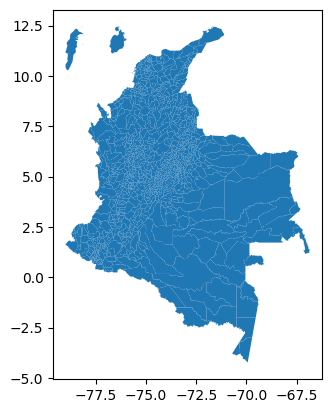

In [66]:
data4.plot()
plt.show()

### <span style = "color:green">Comments</span>

It seems increasing the size before performing the shifting is causing a larger shift than desired when shifting Providencia if we compare this map to the departments map. In this regard, **we should take as the $x$ coordinate shifting reference the westernmost point from the final location of Providencia in the deparments map**. This is saved in a CSV file way above (look for the markdown cell with red text in **Step 3: Move the archipelago closer to mainland** from the departments work).

### Final work

- We repeat the size increase and San Andrés shifting (Steps 1 and 2).
- We then update the Providencia shifting using the shifting reference from the CSV file mentioned in the last comments above (modified Step 3).

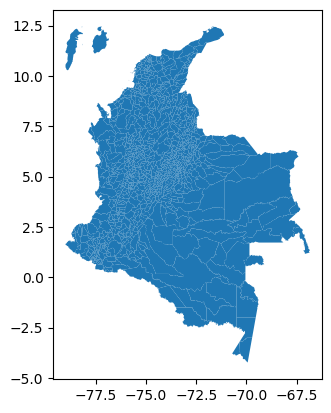

In [67]:
# Increase size
data4 = gpd.read_file('MGN_ANM_MPIOS.geojson')

data4.loc[data4.index == 628, 'geometry'] = \
    data4.loc[data4.index == 628, 'geometry'].scale(xfact = 18, yfact = 18, origin = 'center')
data4.loc[data4.index == 629, 'geometry'] = \
    data4.loc[data4.index == 629, 'geometry'].scale(xfact = 18, yfact = 18, origin = 'center')

# Shift San Andrés
san_andres_x = data4.loc[data4.index == 628,'geometry'].bounds['minx']
san_andres_y = data4.loc[data4.index == 628,'geometry'].bounds['maxy']
ref_x = data4[(data4.index != 628) & (data4.index != 629)].bounds['minx'].min()
ref_y = data4[(data4.index != 628) & (data4.index != 629)].bounds['maxy'].max()
x_offset = (san_andres_x - ref_x)*-1
x_offset = x_offset.values[0]
y_offset = (san_andres_y - ref_y)*-1
y_offset = y_offset.values[0]
data4.loc[data4.index == 628, 'geometry'] = data4.loc[data4.index == 628, 'geometry'].translate(xoff = x_offset, \
                                                                                                yoff = y_offset)

# Shift Providencia
providencia_x = data4.loc[data4.index == 629, 'geometry'].bounds['minx']
providencia_y = data4.loc[data4.index == 629, 'geometry'].bounds['maxy']
# 'ref_x' was computed way above and was called 'town_x_reference'. Here, we load it from a CSV file
ref_y = data4[data4.index == 628].bounds['maxy'].max()
town_x_reference = pd.read_csv('town_x_reference.csv').iloc[0, 0]
x_offset = (providencia_x.values[0] - town_x_reference)*-1
y_offset = (providencia_y - ref_y)*-1
y_offset = y_offset.values[0]
data4.loc[data4.index == 629, 'geometry'] = data4.loc[data4.index == 629, 'geometry'].translate(xoff = x_offset, \
                                                                                                yoff = y_offset)

# Plot results
data4.plot()
plt.show()

In [68]:
# Final esthetic processing
column_list = [0, 1, 2, 4, 5, 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
               17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
               28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
               39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
               50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
               61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
               72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
               83, 84, 85, 86, 87, 88, 89]
data4.drop(data4.columns[column_list], axis = 1, inplace = True)
data4.rename(columns = {'MPIO_CDPMP': 'codigo_municipio_s'}, inplace = True)
data4['codigo_municipio_n'] = data4['codigo_municipio_s'].astype(int)
series = data4['geometry']
data4.drop('geometry', axis = 1, inplace = True)
data4['geometry'] = series
data4.to_file('MGN_ANM_MPIOS_rJAC.geojson', driver = 'GeoJSON')

The final step is to convert the GeoJSON file to a TopoJSON format: 

```bash
geo2topo -q 1e4 MGN_ANM_MPIOS_rJAC.geojson > mapa_municipios.json
```

Below there's a screenshot of how the TopoJSON map looks like in a Power BI dashboard.

![dashboard](../images/dashboard_towns.png)

## Additional sources

- [John Guerra's Observable profile](https://observablehq.com/@john-guerra/topojson-colombia): provides a TopoJSON map of Colombia's towns
- [TopoJSON's GitHub repository](https://github.com/topojson/)
- [topojson server](https://github.com/topojson/topojson-server): instructions to install and use topojson server, the TopoJSON module to convert a GeoJSON to a TopoJSON
- [geo2topo: command not found](https://medium.com/@metakermit/if-you-are-getting-a-command-not-found-geo2topo-thats-because-the-geo2topo-executable-is-now-a-74a0d7dba614): when I first used topojson server, I had issues. In this blogpost I found a workaround
- [GeoPandas API reference](https://geopandas.org/en/stable/docs/reference.html)